# Generate Sensor Data

In this notebook, we will generate synthetic data from a model trained on our real sensor data. 

We use an open-source implementation by Gretel AI found [here](https://github.com/gretelai/gretel-synthetics) of the generative adversarial network known as DoppelGANger. For more information on DoppelGANger, see the [paper](http://arxiv.org/abs/1909.13403) and the respective GitHub [repository](https://github.com/fjxmlzn/DoppelGANger).

In [ ]:
# first, pip installs to ensure we have the correct packages

!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from pickle import dump, load

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

from kafka import KafkaProducer
from time import sleep
import json
import os

In [3]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=720, # sequence length = 720 time units
    sample_len=20, 
    batch_size=min(1000, 300), 
    apply_feature_scaling=True, 
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

# initialize a model with this configuration
model = DGAN(config)

# load in our pretrained model parameters
model = model.load("dgan_model_2.pt", map_location=torch.device('cpu'))

In [4]:
# Generate synthetic data - this line generates 1,000 samples of 12 hour slices of data.
_, synthetic_features = model.generate_numpy(1000)

In [5]:
# our four sensor column names
sensor_cols = ['sensor_25', 'sensor_11', 'sensor_36', 'sensor_34']

# plotting function for a single slice
def plot_12hr_slice(slice, ind):
    for i, c in enumerate(sensor_cols):
        plt.plot(slice[:,i], label=c)
    ax = plt.gca()
    ax.title.set_text("Slice " +str(ind))
    plt.legend(prop={'size': 7})

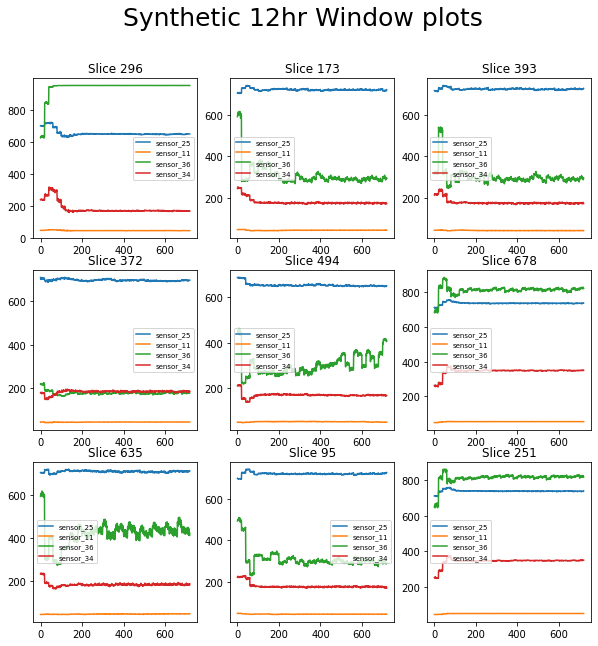

In [6]:
# plot 9 random synthetic windows

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Synthetic 12hr Window plots", fontsize=25, fontweight='roman')

for i in range(9):
    figure.add_subplot(3, 3, i+1)
    index = np.random.choice(1000) # choose a random index from our 1,000 samples
    sl = synthetic_features[index] # select the slice from that index
    plot_12hr_slice(sl, index)
     
plt.show()

### Selecting your slice.

- Now that we have generated 1,000 slices of random data, it's time for you to choose a single slice.

- In the plot above, you can see 9 different plots of slices of data. Above each plot is the slice number. 

- If you don't like the look of any of the plots in this figure, you can re-run the cell above to see another set of 9 random slices.

- Once you see a slice that you like, **enter the corresponding slice number into the cell below where it's marked.**

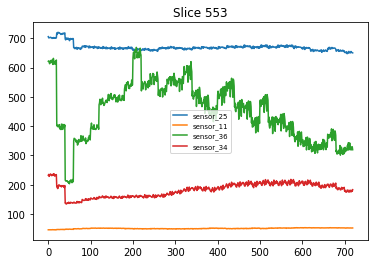

In [46]:
# enter your slice number below
my_slice_num = 553

my_slice = synthetic_features[my_slice_num]

# let's plot that slice to make sure we've got it.
plot_12hr_slice(my_slice, my_slice_num)
plt.show()

### Streaming our sensor data.

- We've got our slice of synthetic sensor data selected now.

- It's time for us to stream our data 'from the sensor' to our model and our database. 

- We'll do so using [Apache Kafka](https://kafka.apache.org/) streaming, an open-source distributed event streaming platform. 


First we need to add some fake timestamps to our data - let's do that by converting our data slice to a pandas dataframe with a column of timestamps and then convert it back to numpy so we can easily work with it as an array.

In [47]:
times = pd.date_range('2022-09-01', periods=720, freq='T')
my_slice_df = pd.DataFrame({'timestamp': times,
                            'sensor_25': my_slice[:,0],
                            'sensor_11': my_slice[:,1],
                            'sensor_36': my_slice[:,2],
                            'sensor_34': my_slice[:,3]})
my_slice_df = my_slice_df.astype({'timestamp':'string'})
my_slice_df.head()

,timestamp,sensor_25,sensor_11,sensor_36,sensor_34
0,2022-09-01 00:00:00,705.827026,46.281727,621.579102,232.550293
1,2022-09-01 00:01:00,701.650269,46.258881,623.145813,235.407471
2,2022-09-01 00:02:00,701.749084,46.061470,620.046875,228.606110
3,2022-09-01 00:03:00,702.423767,46.232719,613.286499,231.915558
4,2022-09-01 00:04:00,702.651611,46.242439,615.176392,233.490997


In [48]:
my_slice = my_slice_df.to_numpy()
my_slice

array([['2022-09-01 00:00:00', 705.8270263671875, 46.2817268371582,
        621.5791015625, 232.55029296875],
       ['2022-09-01 00:01:00', 701.6502685546875, 46.258880615234375,
        623.1458129882812, 235.407470703125],
       ['2022-09-01 00:02:00', 701.7490844726562, 46.06147003173828,
        620.046875, 228.60610961914062],
       ...,
       ['2022-09-01 11:57:00', 652.1160888671875, 52.314205169677734,
        329.84033203125, 181.1962432861328],
       ['2022-09-01 11:58:00', 650.4742431640625, 52.265506744384766,
        329.78497314453125, 177.76959228515625],
       ['2022-09-01 11:59:00', 650.2822265625, 52.58759307861328,
        319.6598815917969, 183.28726196289062]], dtype=object)

Great, we've got our slice setup with some simulated timestamps. Now it's time to start streaming our data.

First let's define how we're going to connect to our kafka cluster.

In [18]:
# todo - clean this up and use environment variables.

# removed server address as im pushing to git.
KAFKA_BOOTSTRAP_SERVER = None

KAFKA_SASL_MECHANISM = os.environ.get('KAFKA_SASL_MECHANISM', 'PLAIN')
KAFKA_SECURITY_PROTOCOL = 'PLAINTEXT'

# SASL username or client ID loaded from the environment variable
KAFKA_USERNAME = os.environ.get('KAFKA_USERNAME')

# SASL password or client secret loaded from the environment variable
KAFKA_PASSWORD = os.environ.get('KAFKA_PASSWORD')

# Name of the topic for the producer to send messages.
# Consumers will listen to this topic for events.
KAFKA_TOPIC = os.environ.get('KAFKA_TOPIC') or 'sensor-topic'

Now, it's time to stream the data. Our function here will connect to the kafka cluster, initialize a KafkaProducer object, and then start streaming messages to our topic.

In [54]:
def produce_data(sensor_slice, slice_num):
    """ generates data every freq for len time """
    """ not sure why i put msg_type but maybe will be useful at some point """
    """ based on the produce_msgs() func from kafka tutorial. """
    # create the producer
    producer = KafkaProducer(bootstrap_servers=[KAFKA_BOOTSTRAP_SERVER],
                             security_protocol=KAFKA_SECURITY_PROTOCOL,
                             sasl_plain_username=KAFKA_USERNAME,
                             sasl_plain_password=KAFKA_PASSWORD,
                             api_version_auto_timeout_ms=30000,
                             max_block_ms=900000,
                             request_timeout_ms=450000,
                             acks='all')
    
    # sending our data 10 rows per second
    for row_index in range(0, 720, 10):
        # select our 10 rows
        ten_rows = sensor_slice[row_index:row_index+10, :]
        # wait a second
        sleep(1)
        for i in range(10):
            one_row = ten_rows[i]
            jsonpayload = json.dumps({'slice_id': slice_num,
                                    'timestamp': one_row[0],
                                    'sensor_25': one_row[1],
                                    'sensor_11': one_row[2],
                                    'sensor_36': one_row[3],
                                    'sensor_34': one_row[4]})
            producer.send(KAFKA_TOPIC, jsonpayload.encode('utf-8'))
    producer.flush()  # Important, especially if message size is small


In [ ]:
produce_data(my_slice, 553)